In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import sys
import tqdm
import pathlib
from pathlib import Path

In [3]:
import gaps_online as go

Can't load CXX API! No module named 'gaps_tof'


In [4]:
import io
import contextlib

In [ ]:
# run_id = 1017

# dataset = pathlib.Path(f'/Users/gracetytus/gaps/test_charge_data/teststand/{run_id}')
# files = [f for f in sorted(dataset.glob('*.tof.gaps'))]
# reader = []
# for file in files:
#     x = go.rust_api.io.TofPacketReader(str(file), filter=go.rust_api.io.PacketType.TofEvent)
#     reader.append(x)
# charge_a = []
# charge_b = []
# for pack in reader:

#   ev = go.rust_api.events.TofEvent()
#   ev.from_tofpacket(pack)

#   #print(ev.waveforms)

#   for x in range(len(ev.hits)):
#       q1 = ev.hits[x].charge_a
#       q2 = ev.hits[x].charge_b
#       charge_a.append(q1)
#       charge_b.append(q2)
        

In [8]:
# run_id = 1017

# dataset = pathlib.Path(f'/Users/gracetytus/gaps/test_charge_data/teststand/{run_id}')
# files = [f for f in sorted(dataset.glob('*.tof.gaps'))]
# f = files[0]
# reader = go.rust_api.io.TofPacketReader(str(f), filter=go.rust_api.io.PacketType.TofEvent)
# charge_a = []
# charge_b = []
# for pack in reader:

#   ev = go.rust_api.events.TofEvent()
#   ev.from_tofpacket(pack)

#   #print(ev.waveforms)

#   for x in range(len(ev.hits)):
#       q1 = ev.hits[x].charge_a
#       q2 = ev.hits[x].charge_b
#       charge_a.append(q1)
#       charge_b.append(q2)
        

In [ ]:
run_id = 134
dataset = pathlib.Path(f'/Volumes/gaps-ssd/134/134')
files = [f for f in sorted(dataset.glob('*.tof.gaps'))]

charge_a_old = []
charge_b_old = []

charge_a_new = []
charge_b_new = []

peak_a_old = []
peak_b_old = []

peak_a_new = []
peak_b_new = []

with contextlib.redirect_stderr(io.StringIO()):
    for f in tqdm.tqdm(files, desc="Processing files", unit="file", file=sys.stdout):
        reader = go.rust_api.io.TofPacketReader(str(f), filter=go.rust_api.io.PacketType.TofEvent)
        settings = go.liftof.LiftofSettings()
        settings = settings.from_file('/Volumes/gaps-ssd/134/134/run134.toml')
        
        for pack in reader:
            ev = go.rust_api.events.TofEvent()
            new_ev = go.liftof.waveform_analysis(ev, settings)
            
            try:
                ev.from_tofpacket(pack)
                new_ev.from_tofpacket(pack) ## do i need to add this line??
                
            except Exception as e:
                pass
                continue
                
            for x in range(len(ev.hits)):
                try:
                    q1_old = ev.hits[x].charge_a
                    q2_old = ev.hits[x].charge_b
                    charge_a_old.append(q1_old)
                    charge_b_old.append(q2_old)

                    v_old_a = ev.hits[x].peak_a
                    v_old_b = ev.hits[x].peak_b
                    peak_a_old.append(v_old_a)
                    peak_b_old.append(v_old_b)
                    
    
                except Exception as e:
                        pass
                        continue
    
            for y in range(len(new_ev.hits)):
                try: 
                    q1_new = new_ev.hits[x].charge_a
                    q2_new = new_ev.hits[x].charge_b
                    charge_a_new.append(q1_new)
                    charge_b_new.append(q2_new)

                    v_new_a = new_ev.hits[x].peak_a
                    v_new_b = new_ev.hits[x].peak_b
                    peak_a_new.append(v_new_a)
                    peak_b_new.append(v_new_b)
                    
                except Exception as e:
                    pass
                    continue

Processing files:  83%|█████████████▎  | 959/1152 [23:38:31<4:51:19, 90.57s/file]

In [ ]:
print(len(files))
print(len(charge_a_old))
print(len(charge_b_old))
print(len(charge_a_new))
print(len(charge_b_new))

33.05185185185185 31.614814814814817 31.981018518518518 31.27453703703704


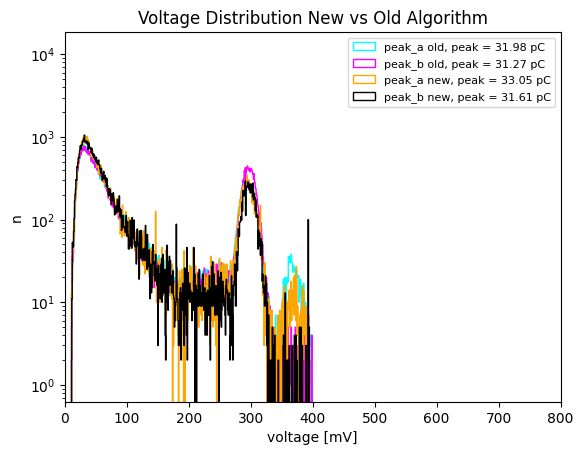

In [24]:
diff_peak_a = [new - old for old, new in zip(peak_a_old, peak_a_new)]
diff_peak_b = [new - old for old, new in zip(peak_b_old, peak_b_new)]

fixed_num_bins = 1080
num_bins = np.linspace(-400,400, fixed_num_bins)
bin_range = (-400, 400) 

counts_a_old, bins_a_old = np.histogram(peak_a_old, bins=fixed_num_bins)
counts_b_old, bins_b_old = np.histogram(peak_b_old, bins=fixed_num_bins)

counts_a_new, bins_a_new = np.histogram(peak_a_new, bins=fixed_num_bins)
counts_b_new, bins_b_new = np.histogram(peak_b_new, bins=fixed_num_bins)

def get_peak_value(counts, bins):
    non_zero_counts = counts[bins[:-1] > 0]  # Exclude the 0 bin
    non_zero_bins = bins[:-1][bins[:-1] > 0]
    peak_bin_index = np.argmax(non_zero_counts)
    return non_zero_bins[peak_bin_index]

# Get peak values
peak_bin_value_a_new = get_peak_value(counts_a_new, bins_a_new)
peak_bin_value_b_new = get_peak_value(counts_b_new, bins_b_new)
peak_bin_value_a_old = get_peak_value(counts_a_old, bins_a_old)
peak_bin_value_b_old = get_peak_value(counts_b_old, bins_b_old)

print(peak_bin_value_a_new, peak_bin_value_b_new, peak_bin_value_a_old, peak_bin_value_b_old)

# Plotting the histograms
plt.figure()
plt.hist(peak_a_old, histtype='step', label=f'peak_a old, peak = {peak_bin_value_a_old:.2f} pC', bins=num_bins, range=bin_range, color='cyan')
plt.hist(peak_b_old, histtype='step', label=f'peak_b old, peak = {peak_bin_value_b_old:.2f} pC', bins=num_bins, range=bin_range, color='magenta')
plt.hist(peak_a_new, histtype='step', label=f'peak_a new, peak = {peak_bin_value_a_new:.2f} pC', bins=num_bins, range=bin_range, color='orange')
plt.hist(peak_b_new, histtype='step', label=f'peak_b new, peak = {peak_bin_value_b_new:.2f} pC', bins=num_bins, range=bin_range, color='black')
plt.xlim(0, 800)
plt.xlabel('voltage [mV]')
plt.ylabel('n')
plt.yscale('log')
plt.title("Voltage Distribution New vs Old Algorithm")
plt.legend(prop={'size': 8})
plt.show()

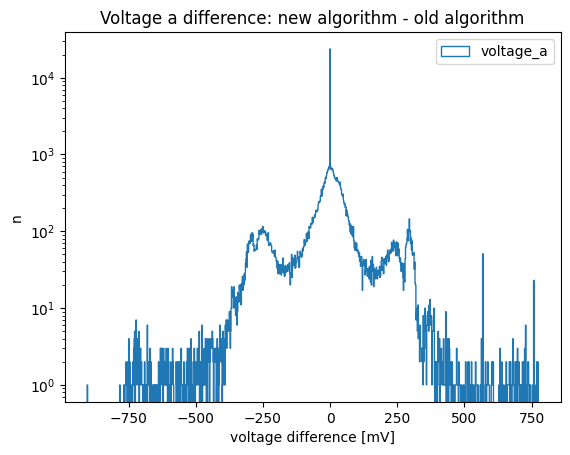

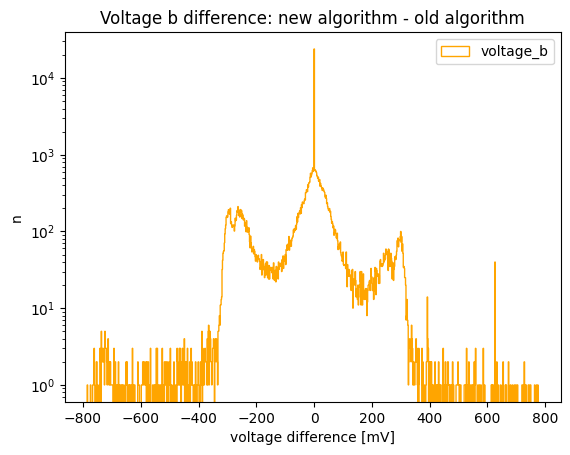

In [19]:
plt.figure()
plt.hist(diff_peak_a, histtype = 'step', label = 'voltage_a', bins = 1000)
plt.xlabel('voltage difference [mV]')
plt.ylabel('n')
#plt.xlim(-20, 20)
plt.title('Voltage a difference: new algorithm - old algorithm')
plt.yscale('log')
plt.legend()
#plt.savefig('/Users/gracetytus/Downloads/' + str(run_id) + 'charge_a_dist_cut.png')
plt.show()

plt.figure()
plt.hist(diff_peak_b, histtype = 'step', label = 'voltage_b', bins = 1000, color = 'orange')
plt.xlabel('voltage difference [mV]')
plt.ylabel('n')
#plt.xlim(-20, 20)
plt.title('Voltage b difference: new algorithm - old algorithm')
plt.yscale('log')
plt.legend()
#plt.savefig('/Users/gracetytus/Downloads/' + str(run_id) + 'charge_b_dist_cut.png')
plt.show()

In [96]:
from matplotlib.lines import Line2D

6.933333333333334 7.425000000000001 6.979166666666666 7.258333333333333


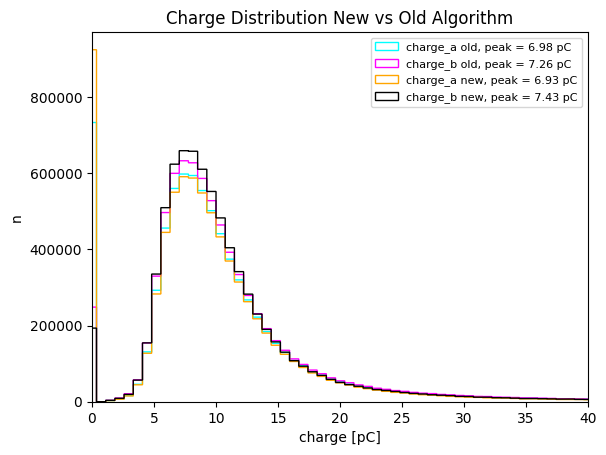

In [114]:
fixed_num_bins = 1080
num_bins = np.linspace(-400,400, fixed_num_bins)
bin_range = (-400, 400) 

counts_a_old, bins_a_old = np.histogram(charge_a_old, bins=fixed_num_bins)
counts_b_old, bins_b_old = np.histogram(charge_b_old, bins=fixed_num_bins)

counts_a_new, bins_a_new = np.histogram(charge_a_new, bins=fixed_num_bins)
counts_b_new, bins_b_new = np.histogram(charge_b_new, bins=fixed_num_bins)

def get_peak_value(counts, bins):
    non_zero_counts = counts[bins[:-1] > 0]  # Exclude the 0 bin
    non_zero_bins = bins[:-1][bins[:-1] > 0]
    peak_bin_index = np.argmax(non_zero_counts)
    return non_zero_bins[peak_bin_index]

# Get peak values
peak_bin_value_a_new = get_peak_value(counts_a_new, bins_a_new)
peak_bin_value_b_new = get_peak_value(counts_b_new, bins_b_new)
peak_bin_value_a_old = get_peak_value(counts_a_old, bins_a_old)
peak_bin_value_b_old = get_peak_value(counts_b_old, bins_b_old)

print(peak_bin_value_a_new, peak_bin_value_b_new, peak_bin_value_a_old, peak_bin_value_b_old)

# Plotting the histograms
plt.figure()
plt.hist(charge_a_old, histtype='step', label=f'charge_a old, peak = {peak_bin_value_a_old:.2f} pC', bins=num_bins, range=bin_range, color='cyan')
plt.hist(charge_b_old, histtype='step', label=f'charge_b old, peak = {peak_bin_value_b_old:.2f} pC', bins=num_bins, range=bin_range, color='magenta')
plt.hist(charge_a_new, histtype='step', label=f'charge_a new, peak = {peak_bin_value_a_new:.2f} pC', bins=num_bins, range=bin_range, color='orange')
plt.hist(charge_b_new, histtype='step', label=f'charge_b new, peak = {peak_bin_value_b_new:.2f} pC', bins=num_bins, range=bin_range, color='black')
plt.xlim(0, 40)
plt.xlabel('charge [pC]')
plt.ylabel('n')
plt.title("Charge Distribution New vs Old Algorithm")
plt.legend(prop={'size': 8})
plt.show()

In [91]:
# Calculate the histogram data for both charge_a_new and charge_b_new
counts_a, bins_a = np.histogram(charge_a_old, bins=1080)
counts_b, bins_b = np.histogram(charge_b_old, bins=1080)

# Exclude the 0 bin and find the peak bin for charge_a
non_zero_counts_a = counts_a[bins_a[:-1] > 0]  # Exclude the 0 bin
non_zero_bins_a = bins_a[:-1][bins_a[:-1] > 0]
peak_bin_index_a = np.argmax(non_zero_counts_a)
peak_bin_value_a = non_zero_bins_a[peak_bin_index_a]

# Exclude the 0 bin and find the peak bin for charge_b
non_zero_counts_b = counts_b[bins_b[:-1] > 0]  # Exclude the 0 bin
non_zero_bins_b = bins_b[:-1][bins_b[:-1] > 0]
peak_bin_index_b = np.argmax(non_zero_counts_b)
peak_bin_value_b = non_zero_bins_b[peak_bin_index_b]

plt.hist(charge_a_old, histtype = 'step', label = 'charge_a', bins = 1080)
plt.hist(charge_b_old, histtype = 'step', label = 'charge_b', bins = 1080)
plt.xlim(0, 40)
plt.title('Charge distribution with old charge calculation algorithm')
plt.axvline(x=peak_bin_value_a, color='blue', linestyle='--', label=f'Peak of charge_a at {peak_bin_value_a:.2f} pC')
plt.axvline(x=peak_bin_value_b, color='orange', linestyle='--', label=f'Peak of charge_b at {peak_bin_value_b:.2f} pC')
plt.legend()
plt.savefig('/Users/gracetytus/Downloads/' + str(run_id) + 'charge_dist_old.png')
plt.show()

KeyboardInterrupt: 

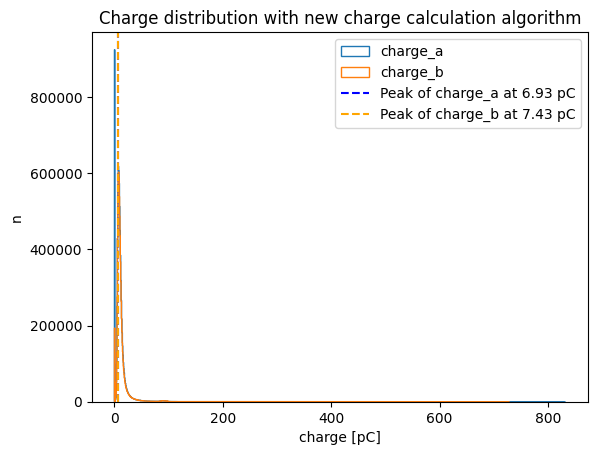

In [85]:
# Calculate the histogram data for both charge_a_new and charge_b_new
counts_a, bins_a = np.histogram(charge_a_new, bins=1080)
counts_b, bins_b = np.histogram(charge_b_new, bins=1080)

# Exclude the 0 bin and find the peak bin for charge_a
non_zero_counts_a = counts_a[bins_a[:-1] > 0]  # Exclude the 0 bin
non_zero_bins_a = bins_a[:-1][bins_a[:-1] > 0]
peak_bin_index_a = np.argmax(non_zero_counts_a)
peak_bin_value_a = non_zero_bins_a[peak_bin_index_a]

# Exclude the 0 bin and find the peak bin for charge_b
non_zero_counts_b = counts_b[bins_b[:-1] > 0]  # Exclude the 0 bin
non_zero_bins_b = bins_b[:-1][bins_b[:-1] > 0]
peak_bin_index_b = np.argmax(non_zero_counts_b)
peak_bin_value_b = non_zero_bins_b[peak_bin_index_b]

plt.figure()
plt.hist(charge_a_new, histtype = 'step', label = 'charge_a', bins = 1080)
plt.hist(charge_b_new, histtype = 'step', label = 'charge_b', bins = 1080)
plt.xlabel('charge [pC]')
plt.ylabel('n')
plt.xlim(0, 40)
plt.title('Charge distribution with new charge calculation algorithm')
plt.axvline(x=peak_bin_value_a, color='blue', linestyle='--', label=f'Peak of charge_a at {peak_bin_value_a:.2f} pC')
plt.axvline(x=peak_bin_value_b, color='orange', linestyle='--', label=f'Peak of charge_b at {peak_bin_value_b:.2f} pC')
plt.legend()
plt.savefig('/Users/gracetytus/Downloads/' + str(run_id) + 'charge_dist_new.png')
plt.show()

In [88]:
diff_charge_a = [new - old for old, new in zip(charge_a_old, charge_a_new)]
diff_charge_b = [new - old for old, new in zip(charge_b_old, charge_b_new)]

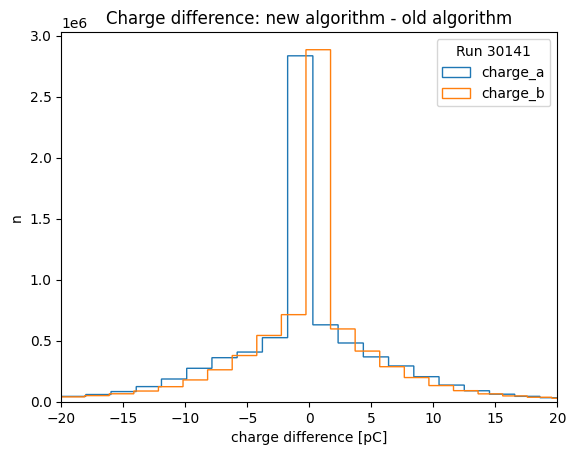

Trigger: GAPS844 + TrackCentral


In [68]:
plt.figure()
plt.hist(diff_charge_a, histtype = 'step', label = 'charge_a', bins = 800)
plt.hist(diff_charge_b, histtype = 'step', label = 'charge_b', bins = 800)
plt.xlabel('charge difference [pC]')
plt.ylabel('n')
plt.xlim(-20, 20)
plt.title('Charge difference: new algorithm - old algorithm')
plt.legend(title = 'Run 30141')
plt.savefig('/Users/gracetytus/Downloads/' + str(run_id) + 'charge_dist_diff_cut.png')
plt.show()

print('Trigger: GAPS844 + TrackCentral')

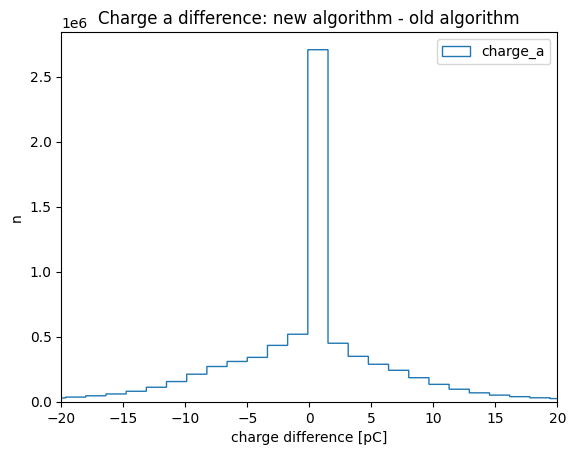

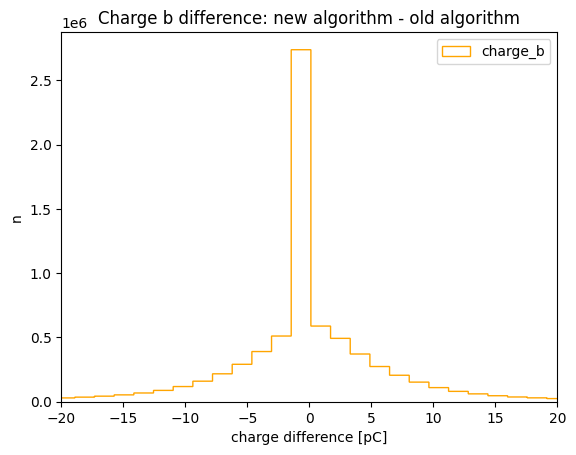

In [72]:
plt.figure()
plt.hist(diff_charge_a, histtype = 'step', label = 'charge_a', bins = 1000)
plt.xlabel('charge difference [pC]')
plt.ylabel('n')
plt.xlim(-20, 20)
plt.title('Charge a difference: new algorithm - old algorithm')
#plt.yscale('log')
plt.legend()
plt.savefig('/Users/gracetytus/Downloads/' + str(run_id) + 'charge_a_dist_cut.png')
plt.show()

plt.figure()
plt.hist(diff_charge_b, histtype = 'step', label = 'charge_b', bins = 1000, color = 'orange')
plt.xlabel('charge difference [pC]')
plt.ylabel('n')
plt.xlim(-20, 20)
plt.title('Charge b difference: new algorithm - old algorithm')
#plt.yscale('log')
plt.legend()
plt.savefig('/Users/gracetytus/Downloads/' + str(run_id) + 'charge_b_dist_cut.png')
plt.show()

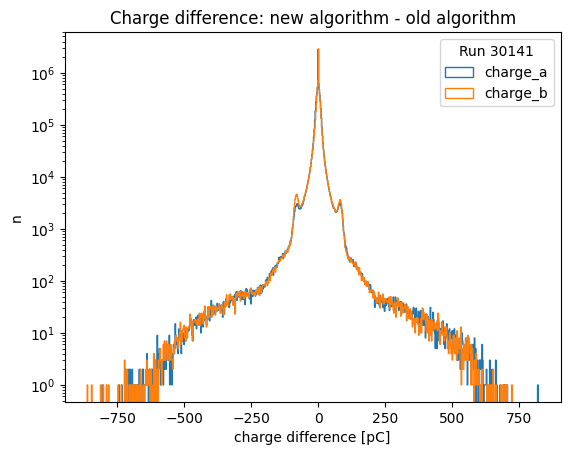

In [74]:
plt.figure()
plt.hist(diff_charge_a, histtype = 'step', label = 'charge_a', bins = 1000)
plt.hist(diff_charge_b, histtype = 'step', label = 'charge_b', bins = 1000)
plt.xlabel('charge difference [pC]')
plt.ylabel('n')
plt.yscale('log')
plt.title('Charge difference: new algorithm - old algorithm')
plt.legend(title = 'Run 30141')
plt.savefig('/Users/gracetytus/Downloads/' + str(run_id) + 'charge_dist_diff.png')
plt.show()

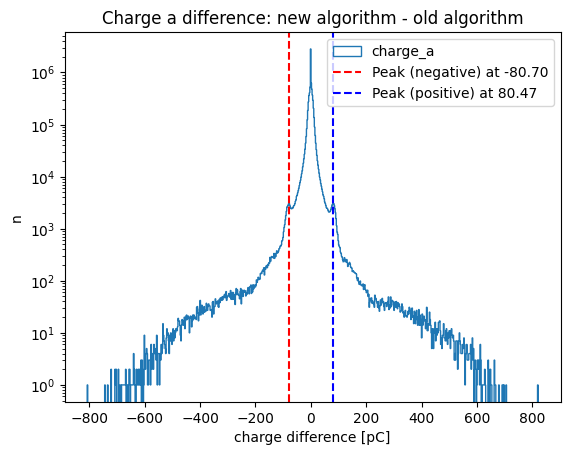

In [79]:
counts, bins = np.histogram(diff_charge_a, bins = 1000)

exclusion_zone = 60  # Exclude bins between -1 and 1

# Get bin centers
bins_center = (bins[:-1] + bins[1:]) / 2

# Split the bins and counts into negative and positive parts, excluding the exclusion zone around 0
negative_bins = bins_center[(bins_center < -exclusion_zone)]
positive_bins = bins_center[(bins_center > exclusion_zone)]

negative_counts = counts[(bins_center < -exclusion_zone)]
positive_counts = counts[(bins_center > exclusion_zone)]
# Find the peak in the negative side
peak_neg_index = np.argmax(negative_counts)
peak_neg_value = negative_bins[peak_neg_index]

# Find the peak in the positive side
peak_pos_index = np.argmax(positive_counts)
peak_pos_value = positive_bins[peak_pos_index]


plt.figure()
plt.hist(diff_charge_a, histtype = 'step', label = 'charge_a', bins = 1000)
plt.xlabel('charge difference [pC]')
plt.ylabel('n')
plt.title('Charge a difference: new algorithm - old algorithm')
plt.yscale('log')
plt.axvline(x=peak_neg_value, color='r', linestyle='--', label=f'Peak (negative) at {peak_neg_value:.2f}')
plt.axvline(x=peak_pos_value, color='b', linestyle='--', label=f'Peak (positive) at {peak_pos_value:.2f}')
plt.legend()
plt.savefig('/Users/gracetytus/Downloads/' + str(run_id) + 'charge_a_dist.png')
plt.show()

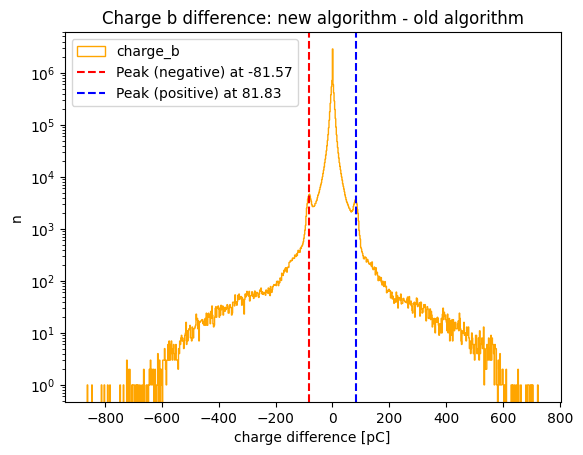

In [81]:
counts, bins = np.histogram(diff_charge_b, bins = 1000)

exclusion_zone = 60  # Exclude bins between -1 and 1

# Get bin centers
bins_center = (bins[:-1] + bins[1:]) / 2

# Split the bins and counts into negative and positive parts, excluding the exclusion zone around 0
negative_bins = bins_center[(bins_center < -exclusion_zone)]
positive_bins = bins_center[(bins_center > exclusion_zone)]

negative_counts = counts[(bins_center < -exclusion_zone)]
positive_counts = counts[(bins_center > exclusion_zone)]
# Find the peak in the negative side
peak_neg_index = np.argmax(negative_counts)
peak_neg_value = negative_bins[peak_neg_index]

# Find the peak in the positive side
peak_pos_index = np.argmax(positive_counts)
peak_pos_value = positive_bins[peak_pos_index]


plt.figure()
plt.hist(diff_charge_b, histtype = 'step', label = 'charge_b', bins = 1000, color = 'orange')
plt.xlabel('charge difference [pC]')
plt.ylabel('n')
plt.title('Charge b difference: new algorithm - old algorithm')
plt.yscale('log')
plt.axvline(x=peak_neg_value, color='r', linestyle='--', label=f'Peak (negative) at {peak_neg_value:.2f}')
plt.axvline(x=peak_pos_value, color='b', linestyle='--', label=f'Peak (positive) at {peak_pos_value:.2f}')
plt.legend()
plt.savefig('/Users/gracetytus/Downloads/' + str(run_id) + 'charge_b_dist.png')
plt.show()